In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.io as sio
import importlib
import pathlib
import os
import sys
import pickle
import itertools 
import seaborn as sns

sys.path.append(os.path.join('..'))
sys.path.append(os.path.join('..', 'plots'))

import sysid as sid
importlib.reload(sid)
import helper
import config_mpl
importlib.reload(config_mpl)


<module 'config_mpl' from '/Users/felixfiedler/Documents/git_repos/2023_Stochastic_MSM/results/../plots/config_mpl.py'>

# Meta analysis system identification of a mass-spring system

In [18]:
settings = {
    'N': 12,
    'T_ini': 3,
    'train_samples': 1000,
    'test_samples': 300, 
    'state_feedback': False,
}

Settings for the investigations.

In [19]:
base_sig_x=np.array([0,0,0,0,0.5])
base_sig_y=2e-2

sig_x_fac = np.array([.1, 1, 2])
sig_y_fac = np.array([.1, 1, 2])

investigations = list(itertools.product(sig_x_fac, sig_y_fac))


In [20]:
np.random.seed(99)

train_data = []

for sig_x_fac_i, sig_y_fac_i in investigations:
    sys_generator = sid.SystemGenerator(
        sys_type=sid.SystemType.BUILDING,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=base_sig_y*sig_y_fac_i,
        dt=1,
        case_kwargs={'state_feedback': settings['state_feedback']}
    )

    data_gen_setup = sid.DataGeneratorSetup(
        T_ini=settings['T_ini'],
        N=settings['N'],
        n_samples=settings['train_samples'],
    )
    # Class that generates a pseudo-random input signal
    random_input = sid.RandomInput(
        n_u=5, 
        u_lb = np.array([-4,-4,-4,-4, 0]).reshape(-1,1),
        u_ub = np.array([4,4,4,4, 30]).reshape(-1,1),
        switch_prob=np.array([0.5, 0.5, 0.5, 0.5, 0.04]).reshape(-1,1)
        )
    
    # Generate data
    train_data.append(sid.DataGenerator(sys_generator, data_gen_setup, random_input))


test_data = []
test_data_true_cov = []

# Generate the same input sequence for all test cases 
random_input_sequence = random_input.gen_sequence(settings['N']+settings['T_ini'])
# Input object that returns the same input sequence
sequence_input = sid.InputFromSequence(random_input_sequence)
# Initial state (identical for all test cases) 
x0_test =np.array([20, 20.5, 19.5, 21, 10]).reshape(-1,1) 
    
for sig_x_fac_i, sig_y_fac_i in investigations:
    # Test data
    test_data_setup = sid.DataGeneratorSetup(
        T_ini=data_gen_setup.T_ini,
        N=data_gen_setup.N,
        n_samples=settings['test_samples'],
    )

    sys_generator_wo_meas_noise = sid.SystemGenerator(
        sys_type=sys_generator.sys_type,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=0,
        dt=sys_generator.dt,
        P0 = np.zeros((5,5)),
        case_kwargs={
            'state_feedback': settings['state_feedback'],
            'x0': x0_test
        },
    )

    # Generate test data
    test_data.append(sid.DataGenerator(sys_generator_wo_meas_noise, test_data_setup, sequence_input))

Text(0.5, 0.98, 'Test data - Same input sequence and without meas. noise')

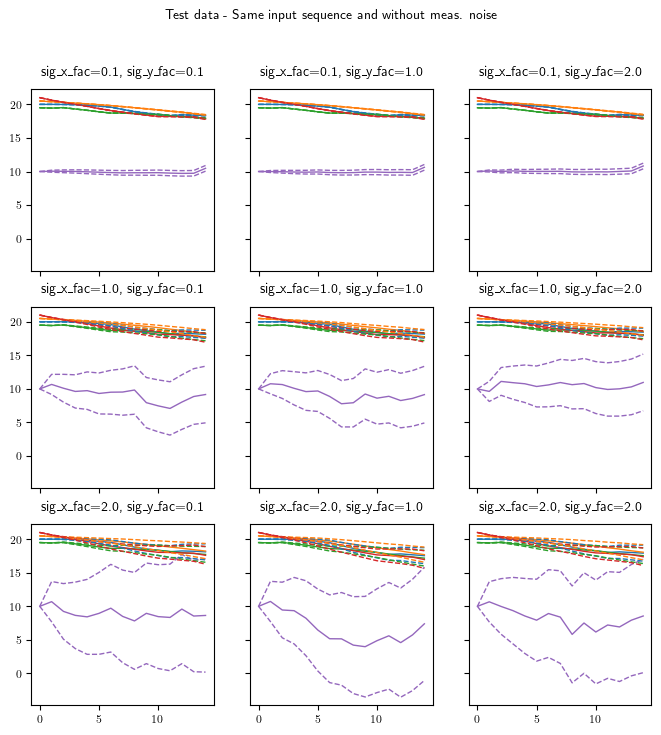

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
std = np.sqrt(np.diagonal(test_data[0].sim_results[0].P, axis1=1, axis2=2))

for i, test_data_i in enumerate(test_data):
    k,j = np.unravel_index(i, (3,3))
    std = np.sqrt(np.diagonal(test_data_i.sim_results[0].P, axis1=1, axis2=2))
    
    ax[k,j].plot(test_data_i.sim_results[0].x)
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].x+3*std, linestyle='--')
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].x-3*std, linestyle='--')
    ax[k,j].set_title(f'sig_x_fac={investigations[i][0]}, sig_y_fac={investigations[i][1]}', fontsize=10)

fig.suptitle('Test data - Same input sequence and without meas. noise')


In [22]:
%%capture

results = []


for i, (train_data_i, test_data_i) in enumerate(zip(train_data, test_data)):
    if i==0:
        msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
        ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
    msm.fit(train_data_i)
    ssm.fit(train_data_i)

    y_msm_pred, y_msm_pred_std = msm.predict(test_data_i.M[:,[0]].T, uncert_type="std", with_noise_variance=True)
    y_msm_pred = y_msm_pred.reshape(-1,test_data_i.n_y)
    y_msm_pred_std = y_msm_pred_std.reshape(-1,test_data_i.n_y)
    y_ssm_pred, y_ssm_pred_std = ssm.predict_sequence(test_data_i.M[:,[0]], with_noise_variance=True)

    msm_cov_final = msm.predict(test_data_i.M[:,[0]].T, uncert_type="cov", with_noise_variance=True)[1][-test_data_i.n_y:, -test_data_i.n_y:]

    results.append(
        {
            'y_msm_pred': y_msm_pred,
            'y_msm_pred_std': y_msm_pred_std,
            'y_ssm_pred': y_ssm_pred,
            'y_ssm_pred_std': y_ssm_pred_std,
            'msm_cov_final': msm_cov_final,
        }
    )

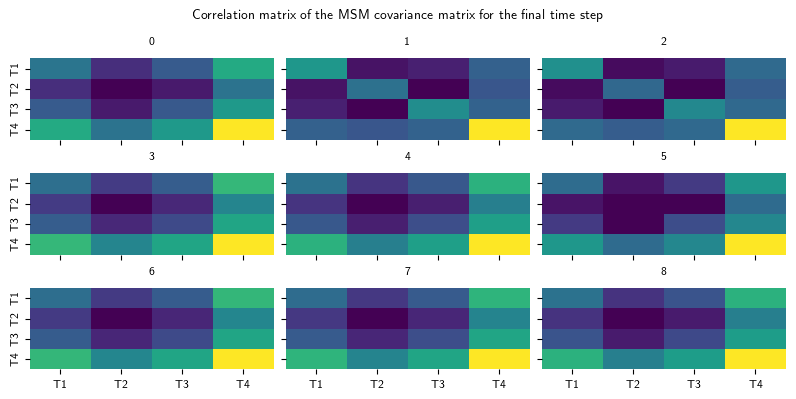

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(8, 4), sharex=True, sharey=True)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))

    names = ['T1', 'T2', 'T3', 'T4']

    if settings['state_feedback']:
        cov = results_i['msm_cov_final'][:-1,:-1]
    else:
        cov = results_i['msm_cov_final']

    corr = pd.DataFrame(cov, index=names, columns=names)

    sns.heatmap(corr, ax=ax[k,j], cmap='viridis', cbar=False)
    ax[k,j].set_title(f'{i}')

fig.suptitle('Correlation matrix of the MSM covariance matrix for the final time step')
fig.tight_layout()

Text(0, 0.5, 'T2')

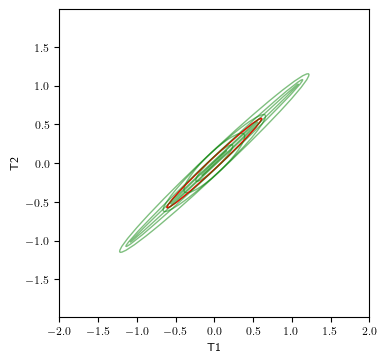

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

ax.axis('equal')

for k in range(len(investigations)):
    cov = results[k]['msm_cov_final']
    helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='g', linewidth=1, alpha=.5)
    if k == 4:
        cov = results[k]['msm_cov_final']
        helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='r', linewidth=1, alpha=1)


ax.set_xlim(-2, 2)
ax.set_ylim(-2,2)

ax.set_xlabel('T1')
ax.set_ylabel('T2')

In [25]:
def get_plot(result, test_data):
    fig, ax = plt.subplots(test_data.n_y,1, sharex=True, figsize=(10,5))

    t_ini = test_data.setup.T_ini

    y_msm_pred = result['y_msm_pred']
    y_msm_pred_std = result['y_msm_pred_std']
    y_ssm_pred = result['y_ssm_pred']
    y_ssm_pred_std = result['y_ssm_pred_std']

    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data.sim_results],axis=2)

    t = test_data.sim_results[0].time[settings['T_ini']:]
    for i in range(test_data.n_y):
        ax[i].plot(t, Y_pred[:,i,:], color='k',linewidth=1, alpha=0.05)

        ax[i].plot(t, y_ssm_pred[:,i],linewidth=2, label="SSM")
        ax[i].fill_between(t, y_ssm_pred[:,i]-3*y_ssm_pred_std[:,i], y_ssm_pred[:,i]+3*y_ssm_pred_std[:,i], alpha=0.3)

        ax[i].plot(t, y_msm_pred[:,i], '--', linewidth=2, label="MSM")
        ax[i].fill_between(t, y_msm_pred[:,i]-3*y_msm_pred_std[:,i], y_msm_pred[:,i]+3*y_msm_pred_std[:,i], alpha=0.3)

    ax[0].plot([],[], color='k', linewidth=1, alpha=0.2, label="Samples")

    ax[0].legend()

    return fig, ax

Text(0.5, 0.98, '$\\sigma_x$=1.0, $\\sigma_y$=2.0')

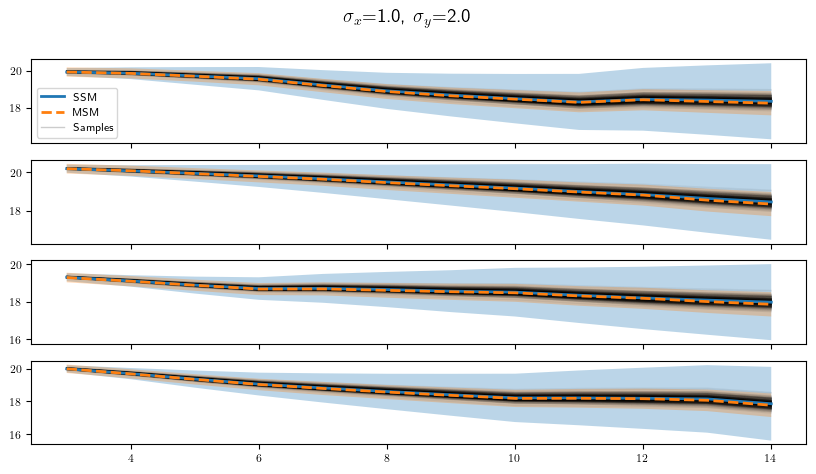

In [26]:
plot_case = 5

fig, ax = get_plot(results[plot_case], test_data[plot_case])
fig.suptitle(f'$\sigma_x$={investigations[plot_case][0]}, $\sigma_y$={investigations[plot_case][1]}', fontsize=14)

In [29]:
def get_normalized_distance(Y_true, y_pred, y_pred_std):
    norm_dist = np.abs(Y_true-np.atleast_3d(y_pred))/np.atleast_3d(y_pred_std)
    return norm_dist

def get_ratio_to_true_std(y_pred_std, true_std):
    ratio = y_pred_std/true_std
    return ratio

def get_stats(Y_true, y_pred, y_pred_std, true_std):
    norm_dist = get_normalized_distance(Y_true, y_pred, y_pred_std)
    in_three_sigma = np.sum(norm_dist < 3)/np.prod(norm_dist.shape)*100
    mse = np.mean((Y_true-np.atleast_3d(y_pred))**2)
    ratio_to_true_std = np.mean(get_ratio_to_true_std(y_pred_std, true_std))

    return in_three_sigma, mse, ratio_to_true_std

In [78]:
results_post_proc = {
    'sigma_x': [],
    'sigma_y': [],
    'msm': {
        'perc. in 3 sigma': [],
        'ratio to true std': [],
        'mse': [],
    },
    'ssm': {
        'perc. in 3 sigma': [],
        'ratio to true std': [],
        'mse': [],
    },
}

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)
    true_std = (np.sqrt(np.diagonal(test_data_i.sim_results[0].P, axis1=1, axis2=2))@test_data_i.sim_results[0].C.T)[data_gen_setup.T_ini:]

    stats_msm = get_stats(Y_pred, results_i['y_msm_pred'], results_i['y_msm_pred_std'], true_std)
    stats_ssm = get_stats(Y_pred, results_i['y_ssm_pred'], results_i['y_ssm_pred_std'], true_std)

    results_post_proc['msm']['perc. in 3 sigma'].append(stats_msm[0])
    results_post_proc['msm']['mse'].append(stats_msm[1])
    results_post_proc['msm']['ratio to true std'].append(stats_msm[2])
    results_post_proc['ssm']['perc. in 3 sigma'].append(stats_ssm[0])
    results_post_proc['ssm']['mse'].append(stats_ssm[1])
    results_post_proc['ssm']['ratio to true std'].append(stats_ssm[2])

    results_post_proc['sigma_x'].append(investigations[i][0])
    results_post_proc['sigma_y'].append(investigations[i][1])

# Normalize mse with smallest value
min_mse = np.min(np.concatenate([results_post_proc['msm']['mse'], results_post_proc['ssm']['mse']]))

print(min_mse)
    


0.00017366835129197658


In [88]:
d1 = pd.DataFrame(results_post_proc['msm'])
d2 = pd.DataFrame(results_post_proc['ssm'])

df_case = pd.DataFrame({'sigma_x': results_post_proc['sigma_x'], 'sigma_y': results_post_proc['sigma_y']})


df = pd.concat([df_case, d1,d2], keys=['empty', 'MSM', 'SSM'],axis=1)

df['MSM']['mse'] /= min_mse
df['SSM']['mse'] /= min_mse


df

/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_32115/3424372426.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSM']['mse'] /= min_mse
/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_32115/3424372426.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SSM']['mse'] /= min_mse


empty                      MSM                                \
  sigma_x sigma_y perc. in 3 sigma ratio to true std         mse   
0     0.1     0.1       100.000000          7.821418    1.024547   
1     0.1     1.0       100.000000          9.537485    1.820031   
2     0.1     2.0       100.000000         13.535626    2.792162   
3     1.0     0.1        99.048611          1.198619  130.044289   
4     1.0     1.0        99.958333          1.345566   95.152877   
5     1.0     2.0        99.805556          1.724638   99.293783   
6     2.0     0.1        99.236111          0.932838  370.807983   
7     2.0     1.0        98.465278          1.019153  458.404686   
8     2.0     2.0        99.944444          1.283580  400.458798   

               SSM                                
  perc. in 3 sigma ratio to true std         mse  
0       100.000000         27.880696    1.000000  
1       100.000000         28.424666    1.596527  
2       100.000000         32.586501    6.570298  
3       100.000000          3.868882  118.222847  
4       100.000000          3.054750   99.887406  
5       100.000000          3.367888   87.064897  
6       100.000000          2.159822  372.317795  
7        99.951389          1.768414  456.684709  
8       100.000000          1.857664  358.788807

In [91]:
tex_str = df.to_latex(
    float_format='{:0.1f}'.format,
    multicolumn=True,
    multirow=True,
    index=False,
)

tex_str = tex_str.replace('perc. in 3 sigma', r'in $\pm3\sigma$')
tex_str = tex_str.replace('ratio to true std', r'$\hat\sigma/\sigma$')
tex_str = tex_str.replace('sigma\\_x', r'$\alpha_{\sigma_a}$')
tex_str = tex_str.replace('sigma\\_y', r'$\alpha_{\sigma_r}$')
tex_str = tex_str.replace('mse', r'MSE$^*$')
tex_str = tex_str.replace('empty', r'&')


tex_str_list = tex_str.split('\n')

tex_str_list.insert(3, r'\cmidrule(lr){3-5} \cmidrule(lr){6-8}')

tex_str_list.pop(1) # Remove toprule

tex_str =  '\n'.join(tex_str_list)

savepath = os.path.join('..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'tables')
savename = 'sid_results_matrix.tex'

with open(os.path.join(savepath, savename), 'w') as f:
    f.write(tex_str)


/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_32115/4043439639.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_str = df.to_latex(


In [92]:
tex_str

'\\begin{tabular}{rrrrrrrr}\n  & & \\multicolumn{3}{l}{MSM} & \\multicolumn{3}{l}{SSM} \\\\\n\\cmidrule(lr){3-5} \\cmidrule(lr){6-8}\n$\\alpha_{\\sigma_a}$ & $\\alpha_{\\sigma_r}$ & in $\\pm3\\sigma$ & $\\hat\\sigma/\\sigma$ &   MSE$^*$ & in $\\pm3\\sigma$ & $\\hat\\sigma/\\sigma$ &   MSE$^*$ \\\\\n\\midrule\n    0.1 &     0.1 &            100.0 &               7.8 &   1.0 &            100.0 &              27.9 &   1.0 \\\\\n    0.1 &     1.0 &            100.0 &               9.5 &   1.8 &            100.0 &              28.4 &   1.6 \\\\\n    0.1 &     2.0 &            100.0 &              13.5 &   2.8 &            100.0 &              32.6 &   6.6 \\\\\n    1.0 &     0.1 &             99.0 &               1.2 & 130.0 &            100.0 &               3.9 & 118.2 \\\\\n    1.0 &     1.0 &            100.0 &               1.3 &  95.2 &            100.0 &               3.1 &  99.9 \\\\\n    1.0 &     2.0 &             99.8 &               1.7 &  99.3 &            100.0 &              

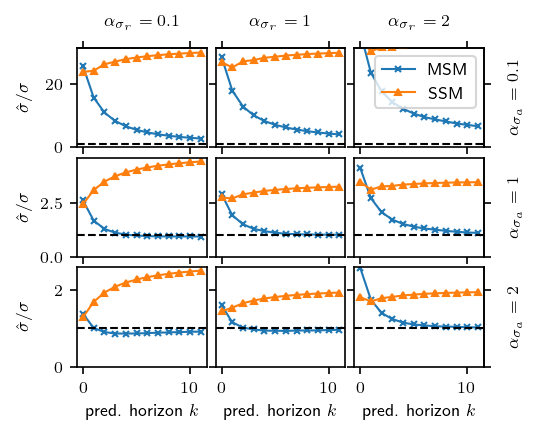

In [34]:

fig, ax = plt.subplots(3, 3, figsize=(config_mpl.columnwidth, .8*config_mpl.columnwidth), sharex=True, sharey='row', dpi=150)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))
    
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)

    true_std = (np.sqrt(np.diagonal(test_data_i.sim_results[0].P, axis1=1, axis2=2))@test_data_i.sim_results[0].C.T)[data_gen_setup.T_ini:]
    mean_ratio_true_std_msm = np.mean(get_ratio_to_true_std(results_i['y_msm_pred_std'], true_std), axis=1)
    mean_ratio_true_std_ssm = np.mean(get_ratio_to_true_std(results_i['y_ssm_pred_std'], true_std), axis=1)

    
    ax[k,j].plot(mean_ratio_true_std_msm, '-x', label='MSM', markersize=3)
    ax[k,j].plot(mean_ratio_true_std_ssm, '-^', label='SSM', markersize=3)    
    ax[k,j].axhline(1, color='k', linestyle='--')

    ax[k,j].set_ylim(0, None)



ax[0,0].set_ylabel(r'$\hat\sigma / \sigma$')
ax[1,0].set_ylabel(r'$\hat\sigma / \sigma$')
ax[2,0].set_ylabel(r'$\hat\sigma / \sigma$')

ax[2,0].set_xlabel(r'pred. horizon $k$')
ax[2,1].set_xlabel(r'pred. horizon $k$')
ax[2,2].set_xlabel(r'pred. horizon $k$')

sec_x_axis = []
sec_y_axis = []
for i in range(3):
    sec_x_axis.append(ax[0,i].secondary_xaxis('top'))
    sec_y_axis.append(ax[i,-1].secondary_yaxis('right'))

    sec_x_axis[i].xaxis.set_ticklabels([])
    sec_y_axis[i].yaxis.set_ticklabels([])

sec_y_axis[0].set_ylabel(r'$\alpha_{\sigma_a} = 0.1$')
sec_y_axis[1].set_ylabel(r'$\alpha_{\sigma_a} = 1$')
sec_y_axis[2].set_ylabel(r'$\alpha_{\sigma_a} = 2$')

sec_x_axis[0].set_xlabel(r'$\alpha_{\sigma_r} = 0.1$')
sec_x_axis[1].set_xlabel(r'$\alpha_{\sigma_r} = 1$')
sec_x_axis[2].set_xlabel(r'$\alpha_{\sigma_r} = 2$')



ax[0,2].legend()


fig.tight_layout(pad = 0.1)
fig.align_labels()

savepath = os.path.join('..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'figures')
savename = 'ratio_ident_vs_true_std'
fig.savefig(os.path.join(savepath, savename + '.pgf'), bbox_inches='tight', format='pgf')

## Export model

In [67]:
%%capture

export_id = 4

train_data_i = train_data[export_id]
msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
msm.fit(train_data_i)
ssm.fit(train_data_i)

sig_x_fac_i, sig_y_fac_i = investigations[export_id]
sigma_x=base_sig_x*sig_x_fac_i
sigma_y=base_sig_y*sig_y_fac_i


In [70]:
result_dir = os.path.join('sid_results')
save_name = "building_prediction_models.pkl"
save_name = os.path.join(result_dir, save_name)

pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)

with open(save_name, "wb") as f:
    res = {'msm': msm, 'ssm': ssm, 'sigma_x': sigma_x, 'sigma_y': sigma_y}
    pickle.dump(res, f)

Check if loading works

In [71]:
with open(save_name, "rb") as f:
    res = pickle.load(f)